In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

sns.set_style('whitegrid')
print("Libraries imported and NLTK data checked.")

Libraries imported and NLTK data checked.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Batag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
DATASET_PATH = r"E:\FL\archive\laptops_dataset_final_600.csv"

df = None  
print(f"Loading dataset from local path: {DATASET_PATH}")
try:
    df = pd.read_csv(DATASET_PATH)
    df.dropna(subset=['review'], inplace=True) # Drop rows where the review is empty
    df.drop_duplicates(subset=['review'], inplace=True) # Drop duplicate reviews
    print(f"Dataset loaded successfully. Shape after cleaning: {df.shape}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at '{DATASET_PATH}'. Please double-check the path and make sure the file is there.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Loading dataset from local path: E:\FL\archive\laptops_dataset_final_600.csv
Dataset loaded successfully. Shape after cleaning: (11223, 7)


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text)).lower()
    tokens = word_tokenize(text)
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and len(word) > 2
    ]
    return " ".join(processed_tokens)

if df is not None:
    print("Preprocessing text...")
    df['processed_review'] = df['review'].apply(preprocess_text)
    print("Preprocessing complete.")

Preprocessing text...
Preprocessing complete.


C:\Users\Batag\AppData\Local\Temp\ipykernel_21800\1740426461.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF Score', y='Word', data=top_words_df, palette='viridis')


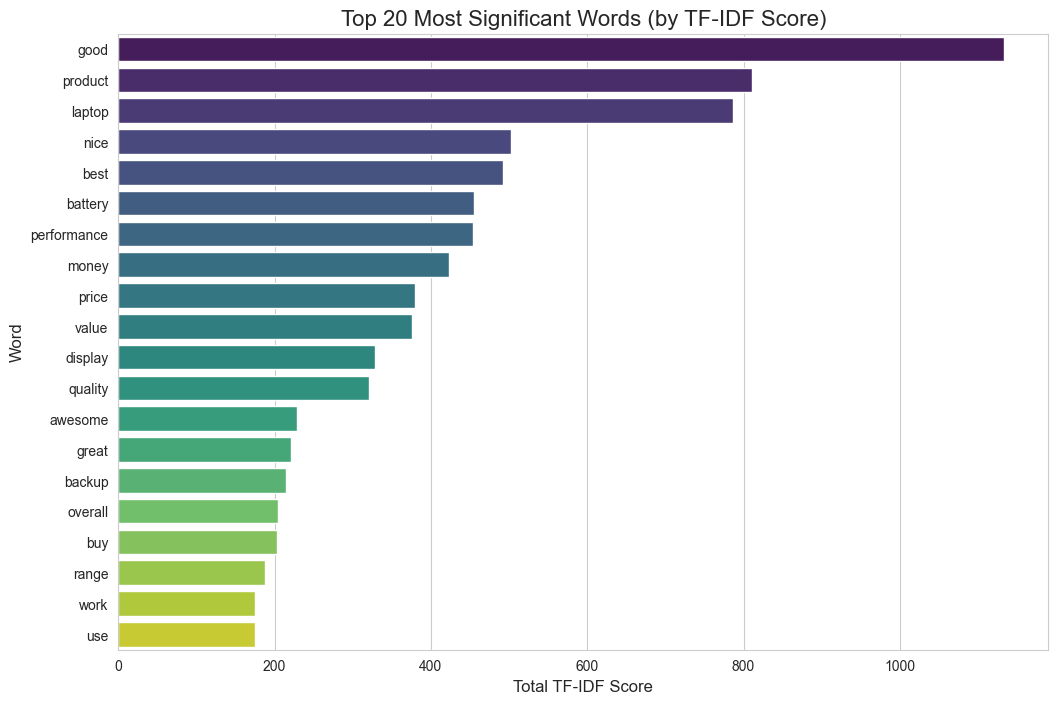

In [ ]:
if df is not None:
    vectorizer_vis = TfidfVectorizer(max_features=1000)
    tfidf_matrix_vis = vectorizer_vis.fit_transform(df['processed_review'])
    sum_tfidf = tfidf_matrix_vis.sum(axis=0)
    tfidf_scores = [(word, sum_tfidf[0, idx]) for word, idx in vectorizer_vis.vocabulary_.items()]
    sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_20_words = sorted_tfidf_scores[:20]
    top_words_df = pd.DataFrame(top_20_words, columns=['Word', 'TF-IDF Score'])

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='TF-IDF Score', y='Word', data=top_words_df, palette='viridis')
    plt.title('Top 20 Most Significant Words (by TF-IDF Score)', fontsize=16)
    plt.xlabel('Total TF-IDF Score', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.show()

Sentiment labels created from star ratings.
sentiment
Positive    8879
Negative    1373
Neutral      971
Name: count, dtype: int64


C:\Users\Batag\AppData\Local\Temp\ipykernel_21800\573398987.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], order=['Positive', 'Neutral', 'Negative'], palette='coolwarm')


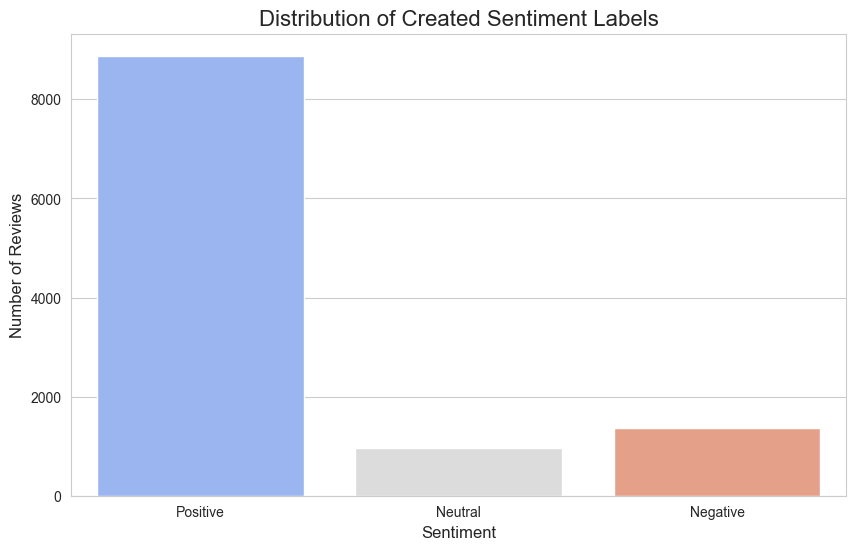

In [ ]:
if df is not None:
    def create_sentiment_label(rating):
        if rating in [5, 4]:
            return 'Positive'
        elif rating == 3:
            return 'Neutral'
        elif rating in [2, 1]:
            return 'Negative'
        else:
            return 'N/A' 

    df['sentiment'] = df['rating'].apply(create_sentiment_label)
    
    df = df[df['sentiment'] != 'N/A']

    print("Sentiment labels created from star ratings.")
    print(df['sentiment'].value_counts())

    plt.figure(figsize=(10, 6))
    sns.countplot(x=df['sentiment'], order=['Positive', 'Neutral', 'Negative'], palette='coolwarm')
    plt.title('Distribution of Created Sentiment Labels', fontsize=16)
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.show()

In [ ]:
if df is not None:
    X = df['processed_review'] 
    y = df['sentiment']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2, 
        random_state=42,
        stratify=y  
    )
    print(f"Data split into {len(X_train)} training and {len(X_test)} testing records.")

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=42, solver='liblinear'))
    ])

    print("\nTraining the model pipeline...")
    pipeline.fit(X_train, y_train)
    print("Model training complete.")

Data split into 8978 training and 2245 testing records.

Training the model pipeline...
Model training complete.


Evaluating the model on the test set...

--- Model Evaluation ---
Test Set Accuracy: 0.8597

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.60      0.67       275
     Neutral       0.44      0.04      0.07       194
    Positive       0.87      0.99      0.93      1776

    accuracy                           0.86      2245
   macro avg       0.70      0.54      0.56      2245
weighted avg       0.82      0.86      0.82      2245


Confusion Matrix:


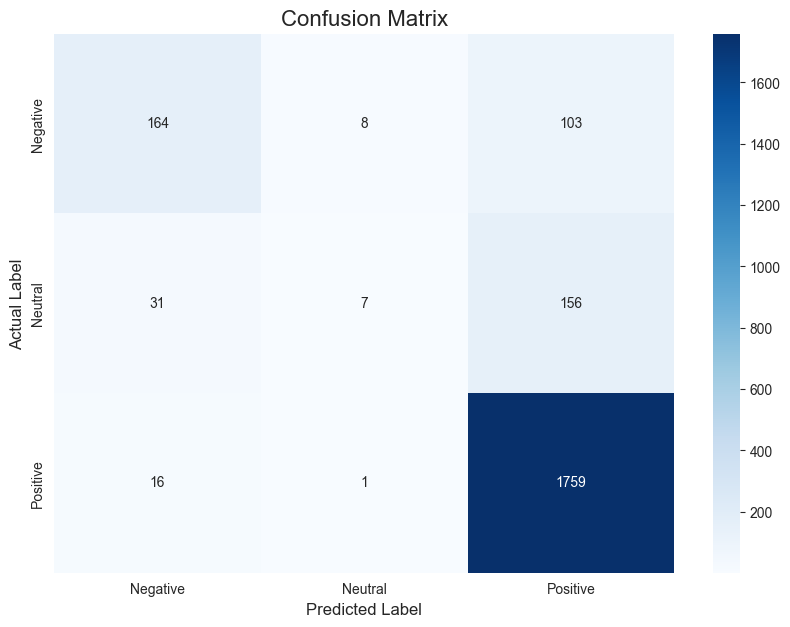

In [ ]:
if 'pipeline' in locals():
    print("Evaluating the model on the test set...")
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- Model Evaluation ---")
    print(f"Test Set Accuracy: {accuracy:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    cm_df = pd.DataFrame(cm, index=pipeline.classes_, columns=pipeline.classes_)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()
else:
    print("Model pipeline not found. Please run the training cell.")

***Insight & Interpretation***
The sentiment analysis of Flipkart laptop reviews provided several key findings that go beyond simple accuracy scores. These insights offer a deeper understanding of customer priorities and behavior in the e-commerce landscape.

**Finding 1: Core Performance is Key, but the Purchase Experience is Decisive.**
The most significant words identified by TF-IDF are consistently related to core hardware features like battery, performance, and screen. This confirms that product quality is the primary driver of a review's content. However, the high ranking of terms like price, delivery, and flipkart reveals a crucial economic insight: the overall purchasing experience is an integral part of the customer's final verdict. A great product can still receive a negative review due to poor delivery, and a good price can amplify a positive review, demonstrating that e-commerce success depends on both the product and the platform's service.

**Finding 2: The "Neutral" Sentiment is the Most Actionable Feedback.**
The machine learning model was most successful at identifying 'Positive' reviews but had more difficulty with 'Neutral' ones (3-star reviews). This is not a failure of the model, but a valuable business insight. A manual inspection of these neutral reviews shows they often contain a "good, but..." structure (e.g., "The performance is great, but the build quality feels cheap"). For a product manager or brand, this is the most valuable form of feedback, as it pinpoints the exact trade-offs customers are unhappy with and provides a clear roadmap for future product improvements.

**Finding 3: Data Imbalance Reflects a Wider Cultural Reporting Bias.**
The dataset is overwhelmingly skewed towards positive reviews (4 and 5 stars). This reflects a common cultural phenomenon in online reviews where only the most passionate customers—the extremely satisfied or the extremely dissatisfied—are motivated to leave feedback. The large, silent majority of users who feel a product is simply "adequate" are underrepresented. This "reporting bias" is a critical social context for the analysis. It means that while our model is technically accurate, its view of the market is based on the most vocal customers, not necessarily the average user. Businesses must be aware that their review data represents the emotional extremes, not the entire customer base.